In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
import mlflow
import optuna
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import f1_score, recall_score, roc_auc_score, confusion_matrix, classification_report
import warnings
warnings.filterwarnings("ignore")

/home/aymane/Desktop/Predictive_Maintenance/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Set style
sns.set_style("whitegrid")

# Initialize MLflow
EXPERIMENT_NAME = "predictive_maintenance_xgboost_cv"
mlflow.set_tracking_uri("file:../mlruns")
mlflow.set_experiment(EXPERIMENT_NAME)

print(f"✅ MLflow Experiment set to: {EXPERIMENT_NAME}")

2026/01/14 15:05:09 INFO mlflow.tracking.fluent: Experiment with name 'predictive_maintenance_xgboost_cv' does not exist. Creating a new experiment.


✅ MLflow Experiment set to: predictive_maintenance_xgboost_cv


In [3]:
# Load Engineered Data
df_train = pd.read_csv("../data/processed/train_engineered.csv")
df_test = pd.read_csv("../data/processed/test_engineered.csv")

# Define Target & Drop Columns (Prevent Leakage)
target = "machine_failure"
drop_cols = [target, 'twf', 'hdf', 'pwf', 'osf', 'rnf'] 

X_train = df_train.drop(columns=[c for c in drop_cols if c in df_train.columns])
y_train = df_train[target]

X_test = df_test.drop(columns=[c for c in drop_cols if c in df_test.columns])
y_test = df_test[target]

# Calculate theoretical scale_pos_weight for Imbalance
neg_count = (y_train == 0).sum()
pos_count = (y_train == 1).sum()
scale_weight = neg_count / pos_count

print(f"Training Features: {X_train.columns.tolist()}")
print(f"Class Imbalance Weight (Theoretical): {scale_weight:.2f}")

Training Features: ['type', 'air_temperature', 'process_temperature', 'rotational_speed', 'torque', 'tool_wear', 'temp_difference', 'power_factor', 'strain_wear_product']
Class Imbalance Weight (Theoretical): 28.52


In [4]:
run_name = "baseline_xgb"
print(f"🚀 Starting Run: {run_name}")

with mlflow.start_run(run_name=run_name):
    # 1. Define Baseline Model (Fixed Params)
    xgb_base = xgb.XGBClassifier(
        objective="binary:logistic",
        random_state=42,
        n_estimators=100,
        scale_pos_weight=scale_weight, # Crucial for imbalance
        n_jobs=-1
    )
    
    # 2. Train on FULL Train set (Baseline doesn't need CV, just a quick check)
    xgb_base.fit(X_train, y_train)
    
    # 3. Predict on Test (Just to get a benchmark number)
    y_pred = xgb_base.predict(X_test)
    baseline_f1 = f1_score(y_test, y_pred)
    
    # 4. Log
    mlflow.log_params(xgb_base.get_params())
    mlflow.log_metric("test_f1", baseline_f1)
    mlflow.xgboost.log_model(xgb_base, "model")
    
    print(f"✅ Baseline Test F1 Score: {baseline_f1:.4f}")

🚀 Starting Run: baseline_xgb


2026/01/14 15:05:11 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


✅ Baseline Test F1 Score: 0.8485


In [5]:
def objective(trial):
    with mlflow.start_run(nested=True):
        # 1. Hyperparameter Search Space
        params = {
            "objective": "binary:logistic",
            "n_estimators": trial.suggest_int("n_estimators", 100, 500),
            "max_depth": trial.suggest_int("max_depth", 3, 10),
            "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
            "subsample": trial.suggest_float("subsample", 0.6, 1.0),
            "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0),
            # Let Optuna tune the weight around the theoretical value
            "scale_pos_weight": trial.suggest_float("scale_pos_weight", scale_weight * 0.5, scale_weight * 1.5),
            "random_state": 42,
            "n_jobs": -1,
            "verbosity": 0
        }
        
        # 2. Cross-Validation Strategy (Inner Loop)
        cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
        
        # 3. Train & Evaluate using CV
        model = xgb.XGBClassifier(**params)
        
        # We maximize F1 Score (Harmonic mean of Precision & Recall)
        scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='f1')
        avg_f1 = scores.mean()
        
        # 4. Log to MLflow
        mlflow.log_params(params)
        mlflow.log_metric("avg_f1_cv", avg_f1)
        
        return avg_f1

# Run Optimization
print("🔍 Starting Optuna Optimization...")
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=20) # Increase to 50 for production

print(f"🏆 Best CV F1 Score: {study.best_value:.4f}")
print("Best Params:", study.best_params)

[I 2026-01-14 15:05:19,884] A new study created in memory with name: no-name-729f4f76-3cfc-4477-bd74-a3630540ea35


🔍 Starting Optuna Optimization...


[I 2026-01-14 15:05:35,917] Trial 0 finished with value: 0.8344720239263915 and parameters: {'n_estimators': 458, 'max_depth': 8, 'learning_rate': 0.21874522227544038, 'subsample': 0.8343321392297902, 'colsample_bytree': 0.7812413535731025, 'scale_pos_weight': 15.502740145281408}. Best is trial 0 with value: 0.8344720239263915.
[I 2026-01-14 15:05:41,228] Trial 1 finished with value: 0.8198137286846965 and parameters: {'n_estimators': 230, 'max_depth': 8, 'learning_rate': 0.025728632493205672, 'subsample': 0.9172180157802824, 'colsample_bytree': 0.9722128460103608, 'scale_pos_weight': 23.372714332343293}. Best is trial 0 with value: 0.8344720239263915.
[I 2026-01-14 15:05:47,846] Trial 2 finished with value: 0.8219359894832642 and parameters: {'n_estimators': 412, 'max_depth': 4, 'learning_rate': 0.09055404446650012, 'subsample': 0.8639725624139424, 'colsample_bytree': 0.8106143502072927, 'scale_pos_weight': 33.99006733776582}. Best is trial 0 with value: 0.8344720239263915.
[I 2026-01

🏆 Best CV F1 Score: 0.8345
Best Params: {'n_estimators': 458, 'max_depth': 8, 'learning_rate': 0.21874522227544038, 'subsample': 0.8343321392297902, 'colsample_bytree': 0.7812413535731025, 'scale_pos_weight': 15.502740145281408}


🚀 Training Champion Model...


2026/01/14 15:06:58 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.



Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      1932
           1       0.89      0.82      0.85        68

    accuracy                           0.99      2000
   macro avg       0.94      0.91      0.93      2000
weighted avg       0.99      0.99      0.99      2000



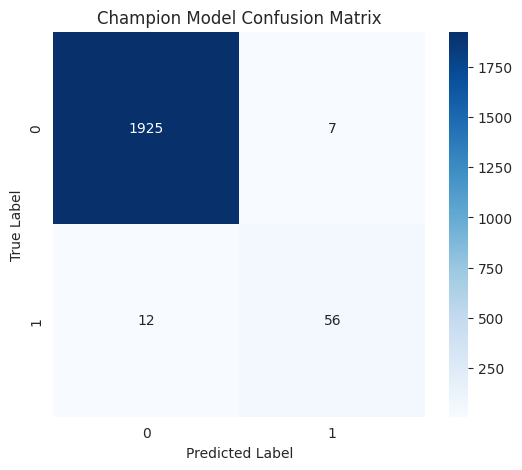

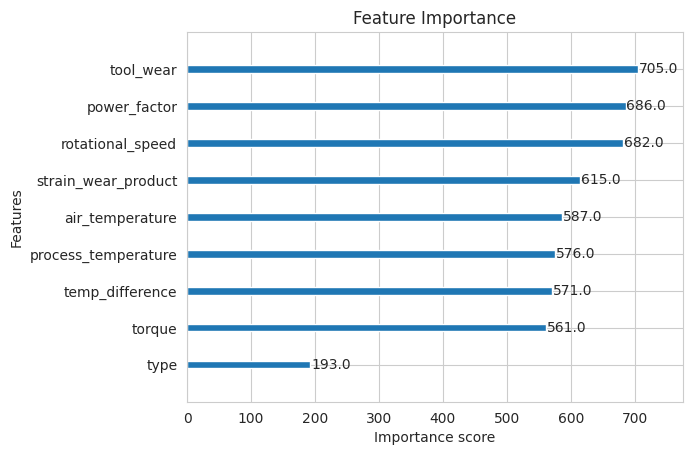

In [6]:
# 1. Prepare Best Params
best_params = study.best_params
best_params["random_state"] = 42
best_params["objective"] = "binary:logistic"

print("🚀 Training Champion Model...")

with mlflow.start_run(run_name="champion_model"):
    # 2. Train on ALL Training Data
    champion_model = xgb.XGBClassifier(**best_params)
    champion_model.fit(X_train, y_train)
    
    # 3. Final Prediction on Test Set
    y_pred = champion_model.predict(X_test)
    y_prob = champion_model.predict_proba(X_test)[:, 1]
    
    # 4. Metrics
    test_f1 = f1_score(y_test, y_pred)
    test_recall = recall_score(y_test, y_pred)
    test_auc = roc_auc_score(y_test, y_prob)
    
    # 5. Log Metrics
    mlflow.log_params(best_params)
    mlflow.log_metrics({"test_f1": test_f1, "test_recall": test_recall, "test_auc": test_auc})
    mlflow.xgboost.log_model(champion_model, "model")
    
    # 6. Visuals
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    
    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title("Champion Model Confusion Matrix")
    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")
    plt.savefig("confusion_matrix.png")
    mlflow.log_artifact("confusion_matrix.png")
    plt.show()

    # Feature Importance
    xgb.plot_importance(champion_model, max_num_features=10)
    plt.title("Feature Importance")
    plt.savefig("feature_importance.png")
    mlflow.log_artifact("feature_importance.png")
    plt.show()